# Detect Four Point Sources (RXJ1131)

This notebook detects the four brightest point-like sources in the JWST cutout,
reports their pixel positions, converts them to arcsec coordinates using `pix_scale=0.031`
assuming image center is `(0, 0)`, and estimates rough fluxes with aperture photometry.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

In [2]:
# Config
pix_scale = 0.031  # arcsec / pixel

CANDIDATE_DATA_DIRS = [
    "../../Data/RXJ1131",
    "../../Data/RXJ1131",
    "/mnt/d/lensing/Herculens/Data/RXJ1131",
]

DATA_DIR = None
for d in CANDIDATE_DATA_DIRS:
    if os.path.exists(d):
        DATA_DIR = d
        break
if DATA_DIR is None:
    raise FileNotFoundError(f"Cannot find RXJ1131 directory. Tried: {CANDIDATE_DATA_DIRS}")

raw_data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d.fits")
data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_150.fits")
mask_path = os.path.join(DATA_DIR, "mask.fits")
mask_out_path = os.path.join(DATA_DIR, "mask_out.fits")

print("DATA_DIR:", DATA_DIR)
print("data_path:", data_path)
print("mask_path:", mask_path)
print("mask_out_path:", mask_out_path)

DATA_DIR: ../../Data/RXJ1131
data_path: ../../Data/RXJ1131/jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_150.fits
mask_path: ../../Data/RXJ1131/mask.fits
mask_out_path: ../../Data/RXJ1131/mask_out.fits


In [3]:
# Load image + error + masks + exposure time
with fits.open(raw_data_path, memmap=True) as hdul_raw:
    exposure_time = float(hdul_raw["SCI"].header["XPOSURE"])

with fits.open(data_path, memmap=True) as hdul:
    data = np.array(hdul["SCI"].data, dtype=float)
    err = np.array(hdul["ERR"].data, dtype=float)

mask = np.array(fits.getdata(mask_path), dtype=bool)
mask_out_raw = np.array(fits.getdata(mask_out_path))
mask_out = np.array(1 - mask_out_raw, dtype=bool)

valid = np.isfinite(data) & np.isfinite(err) & (err > 0) & mask & mask_out

if data.shape != err.shape or data.shape != mask.shape or data.shape != mask_out.shape:
    raise ValueError(
        f"Shape mismatch: data={data.shape}, err={err.shape}, mask={mask.shape}, mask_out={mask_out.shape}"
    )

print("shape:", data.shape)
print("exposure_time:", exposure_time)
print("valid pixels:", int(valid.sum()))

shape: (150, 150)
exposure_time: 1803.776
valid pixels: 9123


In [4]:
# Build working image for peak finding
work = data.copy()
median_fill = np.nanmedian(data[valid])
work[~valid] = median_fill

mean, med, std = sigma_clipped_stats(work[valid], sigma=3.0)
print("sigma-clipped stats:", {"mean": float(mean), "median": float(med), "std": float(std)})

# STARRED-style DAOStarFinder baseline
daofind = DAOStarFinder(
    fwhm=2.5,           # in pixels
    threshold=5.0*std,  # detection threshold
    exclude_border=True,
)

sources = daofind(work - med)
if sources is None or len(sources) == 0:
    raise RuntimeError("No sources found. Try lower threshold or adjust fwhm.")

print("detected sources:", len(sources))
sources.sort("peak")
sources = sources[::-1]  # brightest first
sources[:8]

sigma-clipped stats: {'mean': 0.860191698301441, 'median': 0.7327151894569397, 'std': 0.41275496967791225}
detected sources: 8


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
5,113.27811958582355,70.54132735185283,0.7298521100472966,0.3611924258837687,0.0660572603009957,25,1475.365673482418,7363.601218163967,-9.667725652241412,-6.986581583862323
8,40.752665243696924,107.01962354758025,0.795604982663938,-0.14851894235179586,-0.19002391312763225,25,916.4981197714806,3832.3645629286766,-8.958667039206077,-6.453008577537429
7,103.70397764922618,91.52319253541218,0.6953749226497767,0.33325916965778646,0.09908092215066468,25,831.7112545371056,4286.038650453091,-9.080140207713438,-6.397160146685385
1,70.45014115737013,45.578953741518696,0.6694122096132225,0.39430029301973457,-0.11104911253212345,25,489.9233517050743,2775.915640294552,-8.608515659580187,-5.813236033131705
2,103.99418791797419,64.6385372761637,0.616697269717231,0.7988436429822527,0.26489607327667264,25,6.378731667995453,70.27040094137192,-4.616931078738757,-0.7694254326287662
3,122.45179612192133,64.83455941481404,0.6469910835498939,-0.35495438025150056,-0.31671302935629275,25,5.797003209590912,64.12857168912888,-4.517628917879888,-0.6326865326945662
6,120.83916026089767,76.79760072241739,0.6138205489547487,-0.060779925804097495,-0.5123951503115113,25,5.2934450507164,63.01523977518082,-4.498613982756095,-0.5999702846524217
4,105.3972907018285,69.4842987192641,0.6849051594864347,-0.6167644917717593,-0.9294574817652155,25,5.278885781764984,80.67462891340256,-4.7668424410394925,-0.038804115725880134


In [5]:
# Select 4 distinct brightest peaks with a minimum separation
N_SELECT = 4
MIN_SEP_PIX = 4.0

selected_rows = []
selected_pos = []
for row in sources:
    x = float(row["xcentroid"])
    y = float(row["ycentroid"])
    if all(np.hypot(x - sx, y - sy) >= MIN_SEP_PIX for sx, sy in selected_pos):
        selected_rows.append(row)
        selected_pos.append((x, y))
    if len(selected_rows) == N_SELECT:
        break

if len(selected_rows) < N_SELECT:
    raise RuntimeError(f"Only found {len(selected_rows)} distinct sources; expected {N_SELECT}.")

positions = np.array(selected_pos)
positions

array([[113.27811959,  70.54132735],
       [ 40.75266524, 107.01962355],
       [103.70397765,  91.52319254],
       [ 70.45014116,  45.57895374]])

In [6]:
# Rough flux estimation with aperture photometry
# flux ~ aperture_sum - local_background * aperture_area
r_ap = 3.0
r_in, r_out = 5.0, 8.0

ap = CircularAperture(positions, r=r_ap)
an = CircularAnnulus(positions, r_in=r_in, r_out=r_out)

phot_ap = aperture_photometry(work, ap)
phot_an = aperture_photometry(work, an)

x0 = (work.shape[1] - 1) / 2.0
y0 = (work.shape[0] - 1) / 2.0

rows = []
for i, (x, y) in enumerate(positions, start=1):
    bkg = float(phot_an["aperture_sum"][i-1] / an.area)
    flux = float(phot_ap["aperture_sum"][i-1] - bkg * ap.area)

    x_arcsec = (x - x0) * pix_scale
    y_arcsec = (y - y0) * pix_scale

    rows.append({
        "id": i,
        "x_pix": x,
        "y_pix": y,
        "x_pix_1based": x + 1.0,
        "y_pix_1based": y + 1.0,
        "x_arcsec_centered": x_arcsec,
        "y_arcsec_centered": y_arcsec,
        "flux_aperture_bgsub": flux,
        "local_bkg_per_pix": bkg,
    })

result = pd.DataFrame(rows).sort_values("flux_aperture_bgsub", ascending=False).reset_index(drop=True)
result

,id,x_pix,y_pix,x_pix_1based,y_pix_1based,x_arcsec_centered,y_arcsec_centered,flux_aperture_bgsub,local_bkg_per_pix
0,1,113.278120,70.541327,114.278120,71.541327,1.202122,-0.122719,7322.243777,5.757919
1,3,103.703978,91.523193,104.703978,92.523193,0.905323,0.527719,4334.265307,3.441076
2,2,40.752665,107.019624,41.752665,108.019624,-1.046167,1.008108,3845.772013,2.850655
3,4,70.450141,45.578954,71.450141,46.578954,-0.125546,-0.896552,2846.116295,2.529187


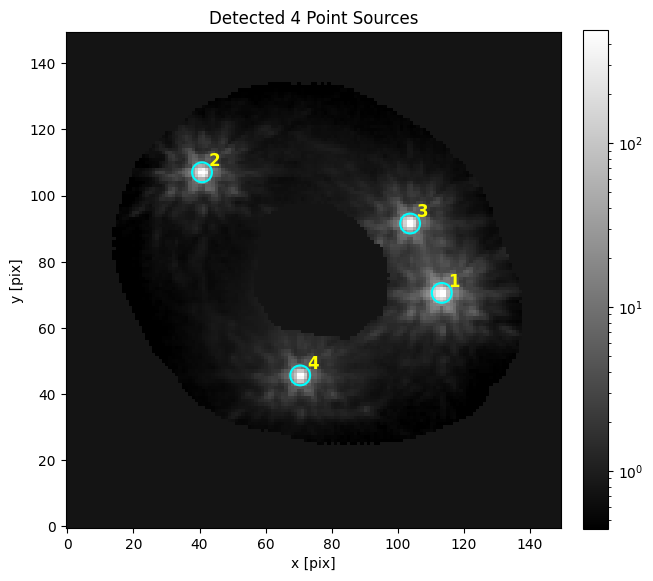

In [7]:
# Plot detections
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(work, origin="lower", cmap="gray", norm=colors.LogNorm(vmin=np.percentile(work[valid], 5), vmax=np.percentile(work[valid], 99.9)))
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ap.plot(ax=ax, color="cyan", lw=1.5)
for _, r in result.iterrows():
    ax.text(r["x_pix"] + 2, r["y_pix"] + 2, f"{int(r['id'])}", color="yellow", fontsize=12, weight="bold")

ax.set_title("Detected 4 Point Sources")
ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
plt.show()

In [ ]:
# Optional: save result table
out_csv = "point_sources_rxj1131_4sources.csv"
result.to_csv(out_csv, index=False)
out_csv